In [1]:
#huggingface libraries 
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TFAutoModel, AutoTokenizer

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, TensorDataset

#random libraries
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import gc
import random

#viz
import matplotlib.pyplot as plt
import seaborn as sns

# set a seed value
torch.manual_seed(555)

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore")

print(torch.__version__)

2.1.2+cu118


##### **Load NLI dataset into dataframe**

In [5]:
dataset = pd.read_csv('/home/ssever/contradictory-information/src/Data/csv_files/nli_data_set.csv')

#### **Split the Dataset into Train and Test**

In [6]:
train, test = train_test_split(dataset, stratify=dataset.label.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [4]:
# check the number of rows and columns after split
print("Train data: {} \n".format(train.shape))
print("Test data: {} \n".format(test.shape))

Train data: (2692, 5) 

Test data: (300, 5) 



In [44]:
#df_check = train
#styled_df = df_check.style.set_properties(**{'text-align': 'left'})
#styled_df.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

#### **Initiate cuda**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cuda')

In [8]:
print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('GPU is:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
GPU is: NVIDIA GeForce RTX 4050 Laptop GPU


#### **Load tokenizer**

In [16]:
tokenizer = AutoTokenizer.from_pretrained('symanto/xlm-roberta-base-snli-mnli-anli-xnli')

#### **Hyperparameter settings**

In [35]:
# Configuration
model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
# model_name = 'bert-base-uncased'
BATCH_SIZE = 16
MAX_LENGTH = 256
NUM_EPOCHS = 1
L_RATE = 5e-6
# NUM_CORES = os.cpu_count()
# NUM_CORES

#### **Encode input sequence**

In [18]:
def preprocess(data, tokenizer):
    kwargs = { 'truncation': True,
    'max_length': MAX_LENGTH,
    'padding': 'max_length',
    'return_attention_mask': True, 
    'return_token_type_ids': True     
    }
    datalist = list(zip(data['premise'], data['hypothesis']))
    tokenized = tokenizer.batch_encode_plus(datalist,**kwargs)
    input_ids = torch.LongTensor(tokenized.input_ids)
    attention_masks = torch.LongTensor(tokenized.attention_mask)
    token_type_ids = torch.LongTensor(tokenized.token_type_ids)
    return input_ids, attention_masks, token_type_ids

In [19]:
# Encode train set

input_ids, attention_masks, token_type_ids = preprocess(train, tokenizer)
labels = torch.Tensor(train['label']).reshape(-1, 1)
train_dataset_final = TensorDataset(input_ids, attention_masks, token_type_ids,labels)
train_dataloader = DataLoader(train_dataset_final, sampler=RandomSampler(train_dataset_final), batch_size=BATCH_SIZE)
len(train_dataloader)

169

In [13]:
len(train_dataloader) * NUM_EPOCHS

169

In [20]:
# Encode test set

input_ids_test, attention_masks_test, token_type_ids_test = preprocess(test,tokenizer)
labels = torch.Tensor(test['label']).reshape(-1, 1)
test_dataset_final = TensorDataset(input_ids_test, attention_masks_test, token_type_ids_test,labels)
test_dataloader = DataLoader(test_dataset_final, sampler=SequentialSampler(test_dataset_final), batch_size=BATCH_SIZE)
len(test_dataloader)

19

#### **Load classification model**

In [ ]:
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=11, output_hidden_states=False, output_attentions=False, problem_type="multi_label_classification")
#model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=11)
config = XLMRobertaConfig.from_pretrained(model_name)
config.num_labels = 11
model = XLMRobertaForSequenceClassification(config)
model.to(device)

In [ ]:
layers_to_unfreeze = list(model.roberta.encoder.layer.children())[-1:]
for layer in layers_to_unfreeze:
        for param in layer.parameters():
            param.requires_grad = True

layers_to_unfreeze

#### **Load and process data into batches**

In [27]:
num_classes = dataset['label'].nunique()
num_classes

11

#### **Train the model**

In [28]:
# Load optimizer
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8
            )

In [29]:
# Garbage collector to free up memory
gc.collect()

26

In [30]:
seed_val = 1024

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
train_loss = []
test_loss = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.set_grad_enabled(True)
    total_train_loss=0
    
    for i,batch in tqdm(enumerate(train_dataloader)):
        model.zero_grad()
        input_ids, attention_masks, token_type_ids, labels=(batch[0].to(device), 
                                                            batch[1].to(device), 
                                                            batch[2].to(device), 
                                                            torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device))
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks, labels=labels)
        loss=outputs[0]
        #if i%10==0:
            #print(f'loss of batch {i}: {loss}')
        total_train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

        # update optimizer
        optimizer.step()
    
    print(f'Training loss on epoch {epoch + 1}: {total_train_loss}')
    train_loss.append(total_train_loss)
    gc.collect()

    # Testing
    
    stacked_val_labels = []
    true_labels = []
    model.eval()

    torch.set_grad_enabled(False)
    total_test_loss = 0

    for j, batch in enumerate(test_dataloader):
        input_ids, attention_masks, token_type_ids,labels=(batch[0].to(device), 
                                                        batch[1].to(device), 
                                                        batch[2].to(device),
                                                torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device))
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks,labels = labels)

        loss = outputs[0]
        logits = outputs.logits
        true = batch[3]

        val_preds = logits.detach().cpu().numpy()
        total_test_loss += loss.item()
        if j == 0:  # first batch
            stacked_val_preds = val_preds
            true_labels = true

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
            true_labels = np.vstack((true_labels, true))
            #stacked_val_preds.extend(val_preds)
        #print(len(stacked_val_preds))
    
    print(f'\n------------------------------------\nTest loss on epoch {epoch + 1}: {total_test_loss}\n------------------------------------\n')

    test_loss.append(total_test_loss)

#### **Testing**

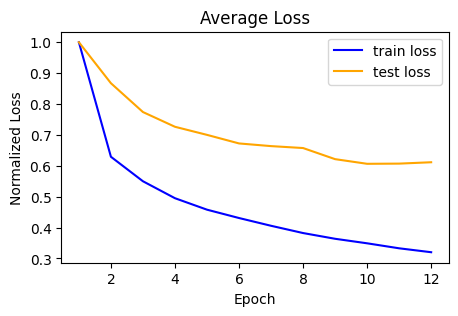

In [45]:
import matplotlib.pyplot as plt

epochs = list(range(1, NUM_EPOCHS + 1))

# Normalize losses for visualization
max_train_loss = max(train_loss)
training_loss_normalized = [loss / max_train_loss for loss in train_loss]
max_test_loss = max(test_loss)
test_loss_normalized = [loss / max_test_loss for loss in test_loss]

# Create the plot
plt.figure(figsize=(5, 3))
plt.plot(epochs, training_loss_normalized, label='train loss', color='blue')
plt.plot(epochs, test_loss_normalized, label='test loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Average Loss')
plt.legend()
plt.show()

In [42]:
stacked_val_labels = []
true_labels = []
model.eval()

torch.set_grad_enabled(False)
total_val_loss = 0

for j, batch in enumerate(test_dataloader):
    input_ids, attention_masks, token_type_ids,labels=(batch[0].to(device), 
                                                        batch[1].to(device), 
                                                        batch[2].to(device),
                                                torch.nn.functional.one_hot(batch[3].to(torch.int64), num_classes=num_classes).squeeze(1).float().to(device))
    outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks,labels = labels)

    loss = outputs[0]
    logits = outputs.logits
    true = batch[3]

    val_preds = logits.detach().cpu().numpy()
    total_val_loss += loss.item()
    if j == 0:  # first batch
        stacked_val_preds = val_preds
        true_labels = true

    else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
        true_labels = np.vstack((true_labels, true))
        #stacked_val_preds.extend(val_preds)
    #print(len(stacked_val_preds))

    
            
print(f'\nPrediction complete.\nAverage loss: {total_val_loss/len(test_dataset_final)}')


Prediction complete.
Average loss: 0.01084020021277786


In [63]:
test_preds = np.argmax(stacked_val_preds, axis=1)

In [64]:
true = true_labels.flatten().astype('int64')

In [65]:
acc = np.sum(test_preds == true)/len(test_preds)
acc

0.43666666666666665

In [66]:
precision, recall, fscore, support = precision_recall_fscore_support(true, test_preds)

In [67]:
score_data = []
for i,(p,r,f,s) in enumerate(zip(precision, recall, fscore, support)):
  score_data.append((i,p,r,f,s))

In [71]:
df = pd.DataFrame(score_data,columns=['label','precision','recall','fscore','support'])
df

,label,precision,recall,fscore,support
0,0,0.000000,0.000000,0.000000,17
1,1,0.455446,0.613333,0.522727,75
2,2,0.000000,0.000000,0.000000,17
3,3,0.000000,0.000000,0.000000,17
4,4,0.000000,0.000000,0.000000,16
5,5,0.000000,0.000000,0.000000,17
6,6,0.693069,0.933333,0.795455,75
7,7,0.000000,0.000000,0.000000,17
8,8,0.154639,0.882353,0.263158,17
9,9,0.000000,0.000000,0.000000,16


In [72]:
# Replace label digits with label strings

string_value_counts = dataset.groupby('label_string')['label'].unique()

formatted_output = {key: value[0] for key, value in string_value_counts.items()}

rev_label_dict = {value: key for key, value in formatted_output.items()}

df['label'] = df['label'].map(rev_label_dict)
df

,label,precision,recall,fscore,support
0,antonymity,0.000000,0.000000,0.000000,17
1,entailment,0.455446,0.613333,0.522727,75
2,factive_antonymity,0.000000,0.000000,0.000000,17
3,factive_embedding_verb,0.000000,0.000000,0.000000,17
4,lexical,0.000000,0.000000,0.000000,16
5,negation,0.000000,0.000000,0.000000,17
6,neutral,0.693069,0.933333,0.795455,75
7,numeric,0.000000,0.000000,0.000000,17
8,structure,0.154639,0.882353,0.263158,17
9,temporal,0.000000,0.000000,0.000000,16


#### Save model

In [12]:
import pickle

model_path = '/home/ssever/contradictory-information/src/xml_roberta.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open(model_path, 'rb') as file:
    model = pickle.load(file)

model.get_parameter

## **Alternative**

#### **Initiate cuda**

In [38]:
gc.collect()

28

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cuda')

In [36]:
print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('GPU is:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
GPU is: NVIDIA GeForce RTX 4050 Laptop GPU


#### **Tokenize and explore train and test sets**

In [37]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [39]:
# Tokenize train and test set

features_train = train[['premise', 'hypothesis']].values.tolist()
features_test = test[['premise', 'hypothesis']].values.tolist()

tokenized_features_train = tokenizer.batch_encode_plus(features_train)
tokenized_features_test = tokenizer.batch_encode_plus(features_test)

In [40]:
# collect tokenized train features sentence length 
token_train_length = [len(x) for x in tokenized_features_train['input_ids']]
print('Longest and shortest input string in Train set: ', '\n' 'Max: ', max(token_train_length))
print('Min: ', min(token_train_length), '\n')


# collect tokenized test features sentence length 
token_test_length = [len(x) for x in tokenized_features_test['input_ids']]
print('Longest and shortest input string in Test set: ', '\n' 'Max: ', max(token_test_length))
print('Min: ', min(token_test_length))

Longest and shortest input string in Train set:  
Max:  131
Min:  16 

Longest and shortest input string in Test set:  
Max:  124
Min:  22


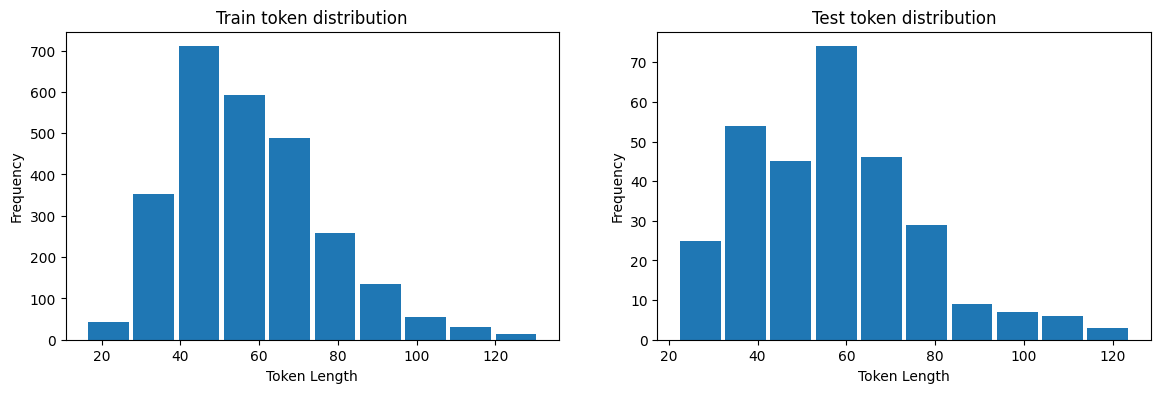

In [41]:
# plot token train and test distribution

fig, axis = plt.subplots(1, 2, figsize=(14, 4))

# Train token plot
axis[0].hist(token_train_length, rwidth = 0.9)
axis[0].set_title("Train token distribution", fontsize = 12)
axis[0].set_xlabel("Token Length")
axis[0].set_ylabel("Frequency") 

# Test token plot
axis[1].hist(token_test_length, rwidth = 0.9)
axis[1].set_title("Test token distribution", fontsize = 12)
axis[1].set_xlabel("Token Length")
axis[1].set_ylabel("Frequency") 

plt.show()

#### **Hyperparameter setting**

In [42]:
# Configuration
MODEL_NAME = 'xlm-roberta-base'
# MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 12
NUM_EPOCHS = 2
L_RATE = 5e-6
MAX_LEN = 256
# NUM_CORES = os.cpu_count()
# NUM_CORES

#### **Load into dataloader**

In [43]:
kwargs = { 'truncation': True,
    'max_length': MAX_LEN,
    'padding': 'max_length',
    'add_special_tokens': True,
    'return_attention_mask': True, 
    'return_tensors': 'pt'     
    }

tokenized_features_train = tokenizer.batch_encode_plus(features_train,**kwargs)
tokenized_features_test = tokenizer.batch_encode_plus(features_test,**kwargs)

In [44]:
# Load train set into data loader

input_ids = torch.LongTensor(tokenized_features_train.input_ids)
attention_masks = torch.LongTensor(tokenized_features_train.attention_mask)
labels = torch.Tensor(train['label']).reshape(-1, 1)

train_set = TensorDataset(input_ids, attention_masks, labels)
train_dataloader = DataLoader(train_set, sampler=RandomSampler(train_set), batch_size=BATCH_SIZE)
print('Number of batches in train set:', len(train_dataloader))

Number of batches in train set: 224


In [45]:
# Load test set into data loader

input_ids = torch.LongTensor(tokenized_features_test.input_ids)
attention_masks = torch.LongTensor(tokenized_features_test.attention_mask)
labels = torch.Tensor(test['label']).reshape(-1, 1)

test_set = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_set, sampler=RandomSampler(test_set), batch_size=BATCH_SIZE)
print('Number of batches in test set:', len(test_dataloader))

Number of batches in test set: 25


In [46]:
NUM_LABELS = dataset['label'].nunique()
NUM_LABELS

11

#### **Load classifier model**

In [ ]:
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=11, output_hidden_states=False, output_attentions=False, problem_type="multi_label_classification")
model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS, output_attentions = False, output_hidden_states = False)
model.to(device)

#### **Load optimizer**

In [48]:
optimizer = AdamW(model.parameters(),
                  lr = L_RATE, 
                  eps = 1e-8 
                )

In [49]:
total_steps = len(train_dataloader) * NUM_EPOCHS
total_steps

448

In [50]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

#### **Train model**

In [51]:
# Training
import time
# Store the average loss after each epoch 
loss_values = []
# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / BATCH_SIZE)
# looping over epochs
for epoch_i in range(0, NUM_EPOCHS):
    
    print('training on epoch: ', epoch_i)
    # set start time 
    t0 = time.time()
    # reset total loss
    total_loss = 0
    # model in training 
    model.train()
    # loop through batch 
    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 step 
        if step % 50 == 0 and not step == 0:
            print('training on step: ', step)
            print('total time used is: {0:.2f} s'.format(time.time() - t0))
        # load data from dataloader 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = torch.nn.functional.one_hot(batch[2].to(torch.int64), num_classes=NUM_LABELS).squeeze(1).float().to(device)
        # clear any previously calculated gradients 
        model.zero_grad()
        # get outputs
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        # get loss
        loss = outputs[0]
        # total loss
        total_loss += loss.item()
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update optimizer
        optimizer.step()
        # update learning rate 
        #scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("average training loss: {0:.2f}".format(avg_train_loss))

total steps per epoch:  18.666666666666668
training on epoch:  0
training on step:  50
total time used is: 36.13 s
training on step:  100
total time used is: 72.08 s
training on step:  150
total time used is: 108.14 s
training on step:  200
total time used is: 144.20 s
average training loss: 0.68
training on epoch:  1
training on step:  50
total time used is: 36.04 s
training on step:  100
total time used is: 72.07 s
training on step:  150
total time used is: 108.13 s
training on step:  200
total time used is: 144.17 s
average training loss: 0.68


In [52]:
t0 = time.time()
# model in test mode
model.eval()
# save prediction
predictions, true_labels =[], []
# evaluate data for one epoch
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # testing
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 16.05 s


In [56]:
# Flatten true labels
true_labels_flat = np.concatenate(true_labels).astype(int).ravel()

# Flatten predictions
predictions_flat = np.concatenate(predictions).ravel()

In [54]:
# Flatten true labels
true_labels_flat = np.concatenate(true_labels).astype(int).ravel()

# Flatten predictions
predictions_flat = np.concatenate(predictions).ravel()

from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(true_labels_flat, 
                           predictions_flat, 
                           output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        75
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        17
           6       0.25      1.00      0.40        75
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00        16

    accuracy                           0.25       298
   macro avg       0.02      0.09      0.04       298
weighted avg       0.06      0.25      0.10       298



In [76]:
from scipy.stats import uniform
learning_rate = 10 ** uniform.rvs(-6, 1)
learning_rate

2.0738865545436455e-06